In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from scipy.stats import norm
import math
sb.set() # set the default Seaborn style for graphics

In [2]:
stream_data = pd.read_csv('Live_Stream_Data.csv')


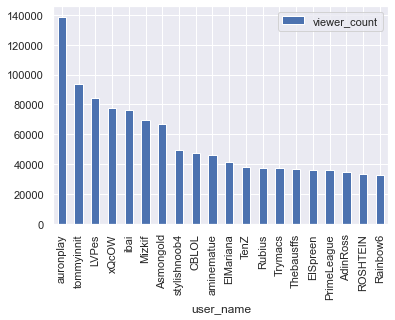

In [3]:
hi = stream_data.drop(columns=['Unnamed: 0', 'id', 'user_login', 'user_id', 'started_at', 'type'])

hi = hi.drop_duplicates(subset=['user_name'], keep='last')
hi = hi.sort_values('viewer_count', ascending=False).head(20)
hi.plot(x='user_name', y='viewer_count', kind='bar')
plt.show()

In [4]:
games = {}
gamestodelete = []
for i in stream_data.index:
    if stream_data.loc[i,'game_name'] not in games:
        games[stream_data.loc[i,'game_name']] = 1
    else:
        games[stream_data.loc[i,'game_name']] += 1
        
for j in games:
    if games[j] < 0.01*i:
        gamestodelete.append(j)
        
for i in stream_data.index:
    if stream_data.loc[i,'game_name'] in gamestodelete:
        stream_data.loc[i,'game_name'] = np.nan
        
stream_data = stream_data.dropna(0,'any')

In [5]:
df = pd.DataFrame()
stream_data = stream_data.dropna(0,'any')
allGamesList = stream_data['game_name'].unique().tolist()

df['game'] = pd.Series(allGamesList)

viewerCountPerGame = []
viewerCountAvgPerGame = []
viewerCountPeakPerGame = []
hoursStreamedPerGame = []
viewerCountModPerGame = []

for x in range(len(allGamesList)):
    viewerCountPerGame.append(0)
    hoursStreamedPerGame.append(0)
    viewerCountPeakPerGame.append(0)
    viewerCountAvgPerGame.append(0)
    viewerCountModPerGame.append(0)

for i, game in enumerate(allGamesList):
    x = stream_data[stream_data['game_name'] == game]
    
    viewerCountPerGame[i] = x['viewer_count'].sum()
    hoursStreamedPerGame[i] = len(x.index)
    viewerCountPeakPerGame[i] = x['viewer_count'].max()
    viewerCountAvgPerGame[i] = math.ceil(x['viewer_count'].mean())
    viewerCountModPerGame[i] = x['viewer_count'].mode().tolist()[-1]
    
df['total_viewers'] = pd.Series(viewerCountPerGame)
df['hours_streamed'] = pd.Series(hoursStreamedPerGame)
df['viewers_avg'] = pd.Series(viewerCountAvgPerGame)
df['viewers_peak'] = pd.Series(viewerCountPeakPerGame)
df['viewers_mod'] = pd.Series(viewerCountModPerGame)

df = df.sort_values('viewers_avg', ascending=False).reset_index(drop=True)
df.head(10)



,game,total_viewers,hours_streamed,viewers_avg,viewers_peak,viewers_mod
0,Sea of Thieves,5483507,298,18402,30639,24631
1,Just Chatting,50389015,2929,17204,110546,42002
2,League of Legends,13033257,1035,12593,336187,8546
3,Phoenix Wright: Ace Attorney,2190552,177,12376,12376,12376
4,Sports,3774565,309,12216,58098,16447
5,Counter-Strike: Global Offensive,2531283,219,11559,158886,942
6,Hollow Knight,2089652,184,11357,11512,11512
7,PUBG: BATTLEGROUNDS,3528704,311,11347,41429,15915
8,VALORANT,9912086,946,10478,71434,18957
9,Slots,2698082,287,9401,36956,3828


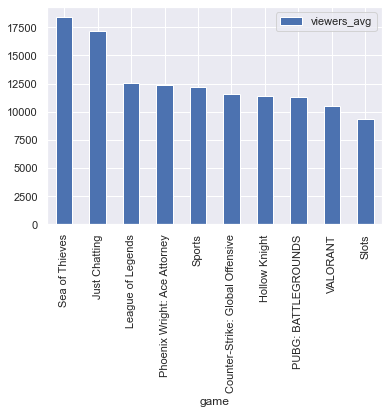

In [6]:
df= df.head(10)
df.plot(x='game', y='viewers_avg', kind='bar')
plt.show()

In [7]:
view = pd.DataFrame(stream_data['viewer_count'])
game = pd.DataFrame(stream_data['game_name'])
lang = pd.DataFrame(stream_data['language'])
time_extracted = pd.DataFrame(stream_data['time_extracted'])

In [8]:
import datetime
for i in time_extracted.index:
    time = datetime.datetime.strptime(time_extracted.loc[i,"time_extracted"],"%Y-%m-%d %H:%M:%S")
    time = datetime.datetime.time(time)
    if time.hour<12 and time.hour>=8:
        time_extracted.loc[i,"time_extracted"] = 'GMT+ 0 to 4'
    elif time.hour>=12 and time.hour<16:
        time_extracted.loc[i,"time_extracted"] = 'GMT+ 4 to 8'
    elif time.hour>=16 and time.hour<20:
        time_extracted.loc[i,"time_extracted"] = 'GMT+ 8 to 12'
    elif time.hour>=20:
        time_extracted.loc[i,"time_extracted"] = 'GMT+ 12 to 16'
    elif time.hour>=0 and time.hour<4:
        time_extracted.loc[i,"time_extracted"] = 'GMT+ 16 to 20'
    elif time.hour>=4 and time.hour<8:
        time_extracted.loc[i,"time_extracted"] = 'GMT+ 20 to 0'           
time_extracted.head()

,time_extracted
0,GMT+ 8 to 12
1,GMT+ 8 to 12
2,GMT+ 8 to 12
6,GMT+ 8 to 12
7,GMT+ 8 to 12


In [9]:

for i in view.index:
    if view.loc[i,'viewer_count'] <= view.quantile(0.1)['viewer_count']:
        view.loc[i,'viewer_count'] = 1
    elif view.loc[i,'viewer_count'] <= view.quantile(0.25)['viewer_count']:
        view.loc[i,'viewer_count'] = 2
    elif view.loc[i,'viewer_count'] <= view.quantile(0.50)['viewer_count']:
        view.loc[i,'viewer_count'] = 3
    elif view.loc[i,'viewer_count']<= view.quantile(0.75)['viewer_count']:
        view.loc[i,'viewer_count'] = 4
    elif view.loc[i,'viewer_count']<= view.quantile(0.9)['viewer_count']:
        view.loc[i,'viewer_count'] = 5
    else:
        view.loc[i,'viewer_count'] = 6

view.head()
view.shape
view.describe()

,viewer_count
count,11371.000000
mean,4.962624
std,1.100057
min,1.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,6.000000


In [10]:
import sklearn
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

try:
    game['game_name'] = le.fit_transform(game['game_name'])
except TypeError:
    print(game['game_name'])
    
try:
    time_extracted['time_extracted'] = le.fit_transform(time_extracted['time_extracted'])
except TypeError:
    print(time_extracted['time_extracted'])
    
try:
    lang['language'] = le.fit_transform(lang['language'])
except TypeError:
    print(lang['language'])

time_extracted.head()

,time_extracted
0,5
1,5
2,5
6,5
7,5


In [11]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(view, test_size = 0.3, random_state = 0)

Xlang_train, Xlang_test = train_test_split(lang, test_size = 0.3, random_state = 0)

Xtime_train, Xtime_test = train_test_split(time_extracted,test_size = 0.3, random_state = 0)

Xgame_train, Xgame_test = train_test_split(game,test_size = 0.3, random_state = 0)

print(Xlang_train)
print(y_train)

       language
5721          2
3379          3
1929          3
10187         7
4465          3
...         ...
5612          3
3782         16
12518        18
13833         3
3085         16

[7959 rows x 1 columns]
       viewer_count
5721              5
3379              3
1929              2
10187             5
4465              5
...             ...
5612              4
3782              5
12518             5
13833             6
3085              5

[7959 rows x 1 columns]


[6 5 5 ... 6 6 6]


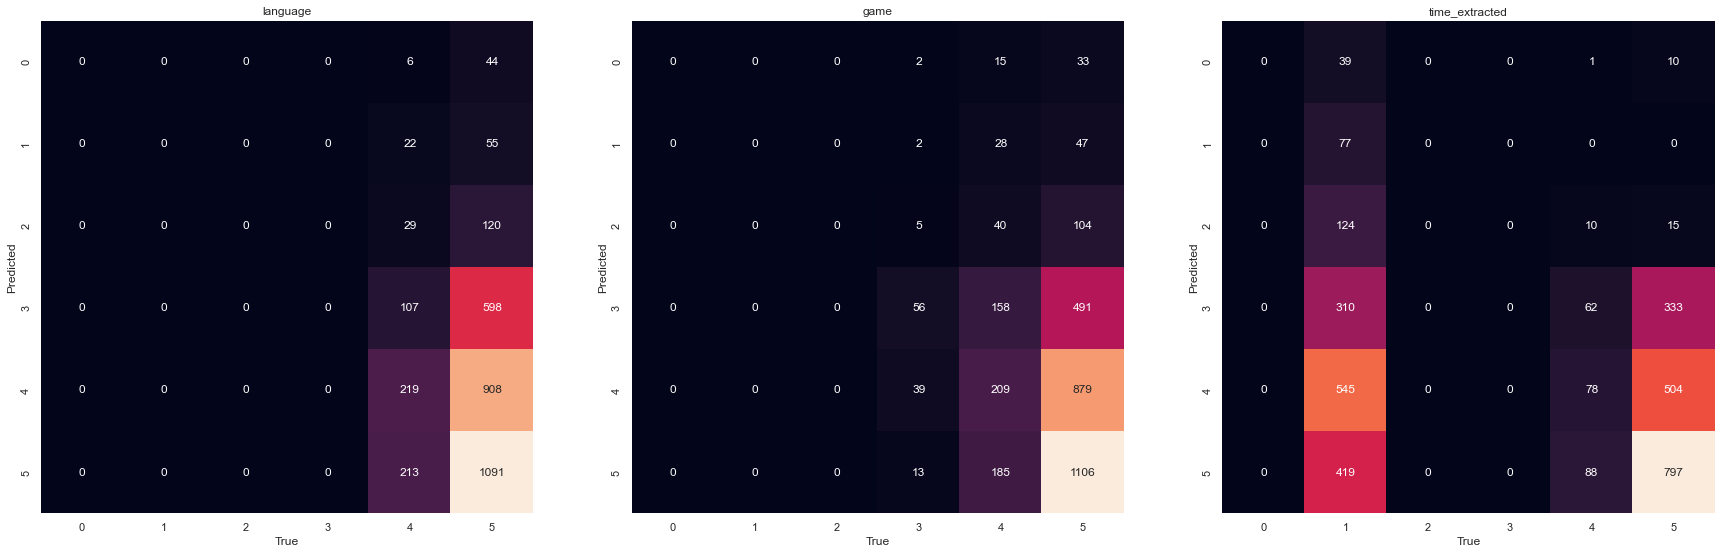

Language accuracy = 0.3839390386869871
Game accuracy = 0.4018171160609613
Time_extracted accuracy = 0.2790152403282532


In [12]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB

f, axes = plt.subplots(ncols = 3, figsize=(30, 12))




classifierLang = GaussianNB()
classifierLang.fit(Xlang_train, y_train['viewer_count'])

# Predicting the Test set results
viewLang_pred = classifierLang.predict(Xlang_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
acLang = accuracy_score(y_test,viewLang_pred)
cmLang = confusion_matrix(y_test, viewLang_pred)


axes[0].set_title('language')
sb.heatmap(cmLang, square=True, annot=True, fmt='d', cbar=False,ax = axes[0])




classifierGame = GaussianNB()
classifierGame.fit(Xgame_train, y_train['viewer_count'])
# Predicting the Test set results
viewGame_pred = classifierGame.predict(Xgame_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
acGame = accuracy_score(y_test,viewGame_pred)
cmGame = confusion_matrix(y_test, viewGame_pred)


axes[1].set_title('game')
sb.heatmap(cmGame, square=True, annot=True, fmt='d', cbar=False,ax = axes[1])


print(viewGame_pred)





classifierTime = GaussianNB()
classifierTime.fit(Xtime_train, y_train['viewer_count'])
# Predicting the Test set results
viewTime_pred = classifierTime.predict(Xtime_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
acTime = accuracy_score(y_test,viewTime_pred)
cmTime = confusion_matrix(y_test, viewTime_pred)


axes[2].set_title('time_extracted')
sb.heatmap(cmTime, square=True, annot=True, fmt='d', cbar=False,ax = axes[2])











for i in axes:
    i.set(xlabel='True', ylabel='Predicted')
plt.show()

print('Language accuracy = ' + str(acLang))
print('Game accuracy = ' + str(acGame))
print('Time_extracted accuracy = ' + str(acTime))

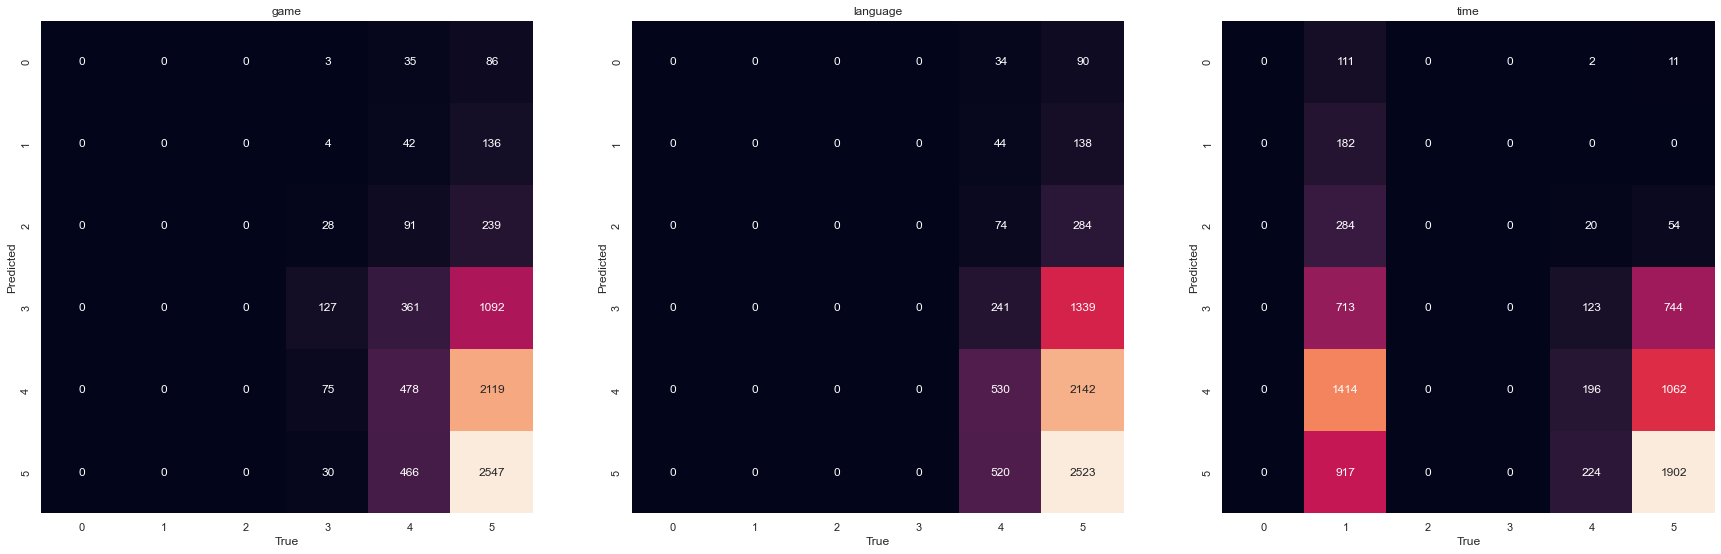

Language accuracy = 0.3835909033798216
Game accuracy = 0.39602965196632745
Time_extracted accuracy = 0.28646814926498304


In [13]:
f, axes = plt.subplots(ncols = 3, figsize=(30, 12))


classifierGame = GaussianNB()
classifierGame.fit(Xgame_train, y_train['viewer_count'])
game_trainPredict = classifierGame.predict(Xgame_train)

acGame = accuracy_score(y_train, game_trainPredict)
cmGame = confusion_matrix(y_train, game_trainPredict)

axes[0].set_title('game')
sb.heatmap(cmGame, square=True, annot=True, fmt='d', cbar=False,ax = axes[0])


classifierLang = GaussianNB()
classifierLang.fit(Xlang_train, y_train['viewer_count'])
lang_trainPredict = classifierLang.predict(Xlang_train)

acLang = accuracy_score(y_train, lang_trainPredict)
cmLang = confusion_matrix(y_train, lang_trainPredict)

axes[1].set_title('language')
sb.heatmap(cmLang, square=True, annot=True, fmt='d', cbar=False,ax = axes[1])


classifierTime = GaussianNB()
classifierTime.fit(Xtime_train, y_train['viewer_count'])
time_trainPredict = classifierTime.predict(Xtime_train)

acTime = accuracy_score(y_train, time_trainPredict)
cmTime = confusion_matrix(y_train, time_trainPredict)

axes[2].set_title('time')
sb.heatmap(cmTime, square=True, annot=True, fmt='d', cbar=False,ax = axes[2])




for i in axes:
    i.set(xlabel='True', ylabel='Predicted')
plt.show()

print('Language accuracy = ' + str(acLang))
print('Game accuracy = ' + str(acGame))
print('Time_extracted accuracy = ' + str(acTime))




In [14]:
features = pd.DataFrame.join(time_extracted,game)
features = pd.DataFrame.join(features,lang)

try:
    features['game_name'] = le.fit_transform(features['game_name'])
except TypeError:
    print(features['game_name'])
    
try:
    features['time_extracted'] = le.fit_transform(features['time_extracted'])
except TypeError:
    print(features['time_extracted'])
    
try:
    features['language'] = le.fit_transform(features['language'])
except TypeError:
    print(features['language'])
    

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

features = scaler.fit_transform(features)
features = pd.DataFrame(features, columns=['time_extracted','game_name','language'])
features.head()


features.shape
features.describe()

,time_extracted,game_name,language
count,11371.000000,11371.000000,11371.000000
mean,-0.222408,-0.077023,0.665359
std,0.593120,0.935388,1.014342
min,-1.333333,-1.833333,-0.600000
25%,-0.666667,-0.666667,0.000000
50%,0.000000,0.000000,0.000000
75%,0.333333,0.333333,1.000000
max,0.333333,1.666667,3.400000


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, view, test_size = 0.3, random_state = 0)

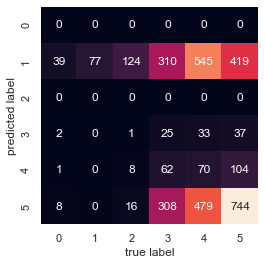

0.268464243845252


In [17]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train['viewer_count'])

# Predicting the Test set results
view_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
ac = accuracy_score(y_test,view_pred)
cm = confusion_matrix(y_test, view_pred)

sb.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

print(ac)

In [ ]:
view_trainPredict = classifier.predict(X_train)

ac = accuracy_score(y_train,view_trainPredict)
cm = confusion_matrix(y_train, view_trainPredict)

sb.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

print(ac)

In [ ]:
print('train score: ' + str(classifier.score(X_train, y_train)))

print('test score: ' + str(classifier.score(X_test, y_test)))